# Computational Methods for Physicists Final Project
## Title: Asteroid Motion Tracking
### Duration: 14 Days (Start Date: Tuesday, April 29, 2025, Due Date: During finals week)

---

## 1. Introduction

This is your final project for this class!

In this project, you will analyze the motion of an asteroid captured in a sequence of astronomical images taken over several nights. The objective is to track the asteroid's position relative to background stars, calculate its apparent speed, and model its trajectory.

You will work with a sequence of FITS images that show both stars and a moving asteroid. The challenge is to identify the asteroid in each frame, extract its coordinates, and analyze how it moves across the sky. By measuring its displacement over time, you will estimate the asteroid's velocity in arcseconds per hour and discuss how astronomers predict asteroid paths.

**Project Topic:** Tracking asteroid motion using time-series astronomical data.

**Key Focus:** Object detection, coordinate measurement, motion analysis.

## 2. Learning Objectives

By completing this project, you will:
- Learn to work with time-series astronomical FITS data.
- Apply computational methods to detect and measure moving objects.
- Interpret motion data to estimate speeds and predict trajectories.
- Document your process clearly in a reproducible way.

## 3. Dataset Description

**You will receive:**
- A series of FITS images captured during one night.
- Each image contains stars and a moving asteroid.

The FITS images include:
- Time information indicating when each image was taken.
- Location information about the observing site.

You will use this metadata to analyze the motion of the asteroid across the sky during the observation period.

## 4. Project Tasks (Total: 28 Points)

### Task 1: Data Exploration and Visualization (6 points)

- Load all FITS images and inspect their contents.
- Display several images to visually confirm the presence and motion of the asteroid.
- Highlight the asteroid in each displayed image by marking it with a circle.
- Generate a final composite image by overlaying all frames to show the asteroid's path as it moves across the sky.

# Installing Required Libraries

In [1]:

# Install required libraries
!pip install astropy matplotlib numpy photutils auto-stretch astroquery ipytest pytest


In [2]:
#---------Basic Imports-----------#
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import requests
from io import BytesIO
from tqdm import tqdm
from random import randint
#---------Astropy Imports-----------#
import astroquery
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.stats import mad_std
import photutils
from photutils.detection import DAOStarFinder
import auto_stretch
from auto_stretch import apply_stretch



# Loading Fits Files

Processing: Stacked_5_73 Leonis_10.0s_IRCUT_20250427-221237.fit
Processing: Stacked_10_73 Leonis_10.0s_IRCUT_20250427-223915.fit
Processing: Stacked_92_73 Leonis_10.0s_IRCUT_20250427-234644.fit
Processing: Stacked_30_73 Leonis_10.0s_IRCUT_20250428-020001.fit
Processing: Stacked_156_73 Leonis_10.0s_IRCUT_20250428-234001.fit
Processing: Stacked_91_73 Leonis_10.0s_IRCUT_20250429-020001.fit


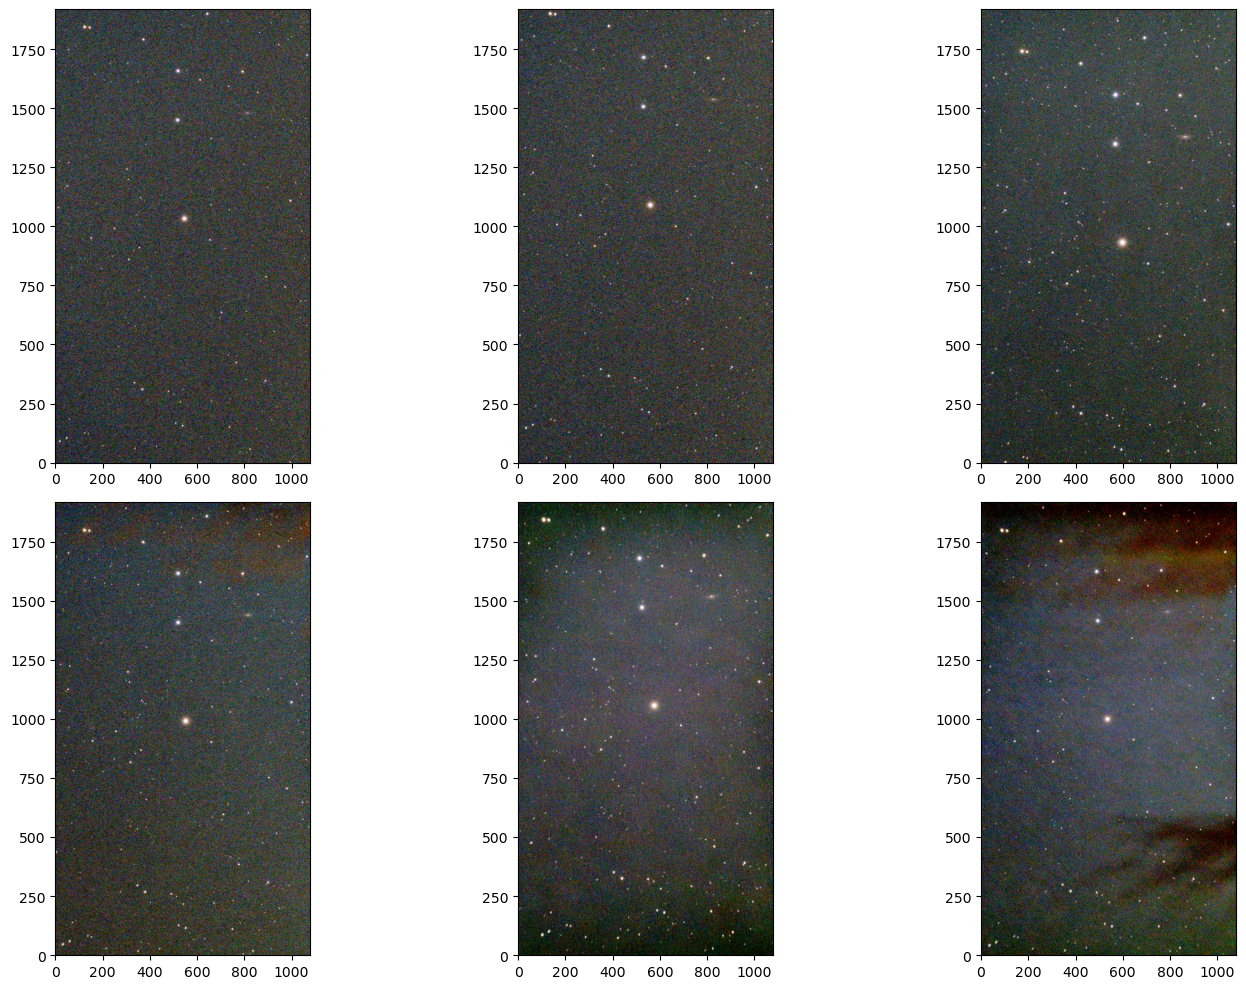

In [3]:
# Base URL of the GitHub folder containing the FITS files
base_url = "https://github.com/DDarrigo-Brick/PHY386/raw/refs/heads/main/2025/Final/DDarrigo-Brick/Flora/Data/"

# List of FITS files
fits_files = [
    "Stacked_5_73 Leonis_10.0s_IRCUT_20250427-221237.fit",
    "Stacked_10_73 Leonis_10.0s_IRCUT_20250427-223915.fit",
    "Stacked_92_73 Leonis_10.0s_IRCUT_20250427-234644.fit",
    "Stacked_30_73 Leonis_10.0s_IRCUT_20250428-020001.fit",
    "Stacked_156_73 Leonis_10.0s_IRCUT_20250428-234001.fit",
    "Stacked_91_73 Leonis_10.0s_IRCUT_20250429-020001.fit"
]
# # Loop through each FITS file and process the images
# for fits_file in fits_files:
#     fits_url = base_url + fits_file
#     print(f"Processing: {fits_file}")

#     try:
        
#         # # Display the image
#         # fig = plt.figure()
#         # plt.imshow(apply_stretch(star_data))

#     except Exception as e:
#         print(f"Error processing {fits_file}: {e}")


# Create a figure with subplots for all six FITS images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through each FITS file and plot on the corresponding subplot
for i, fits_file in enumerate(fits_files):
    fits_url = base_url + fits_file
    print(f"Processing: {fits_file}")

    try:
        # Fetch the FITS file
        response = requests.get(fits_url)
        response.raise_for_status()

       # Load the FITS file into an HDUList using BytesIO
        hdul = fits.open(BytesIO(response.content))

        # Assume the first extension contains an RGB image in (3, Height, Width) format
        star_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
        hdul.close() #

        # Plot the image on the corresponding subplot
        ax = axes[i]
        ax.imshow(apply_stretch(star_data), origin='lower')
        
    except Exception as e:
        print(f"Error processing {fits_file}: {e}")
        axes[i].set_title("Error")
        axes[i].axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

# Identifying Asteroid Based on Movement

Processing: Stacked_5_73 Leonis_10.0s_IRCUT_20250427-221237.fit


c:\Users\Dominic\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Processing: Stacked_10_73 Leonis_10.0s_IRCUT_20250427-223915.fit
Processing: Stacked_92_73 Leonis_10.0s_IRCUT_20250427-234644.fit
Processing: Stacked_30_73 Leonis_10.0s_IRCUT_20250428-020001.fit
Processing: Stacked_156_73 Leonis_10.0s_IRCUT_20250428-234001.fit
Processing: Stacked_91_73 Leonis_10.0s_IRCUT_20250429-020001.fit


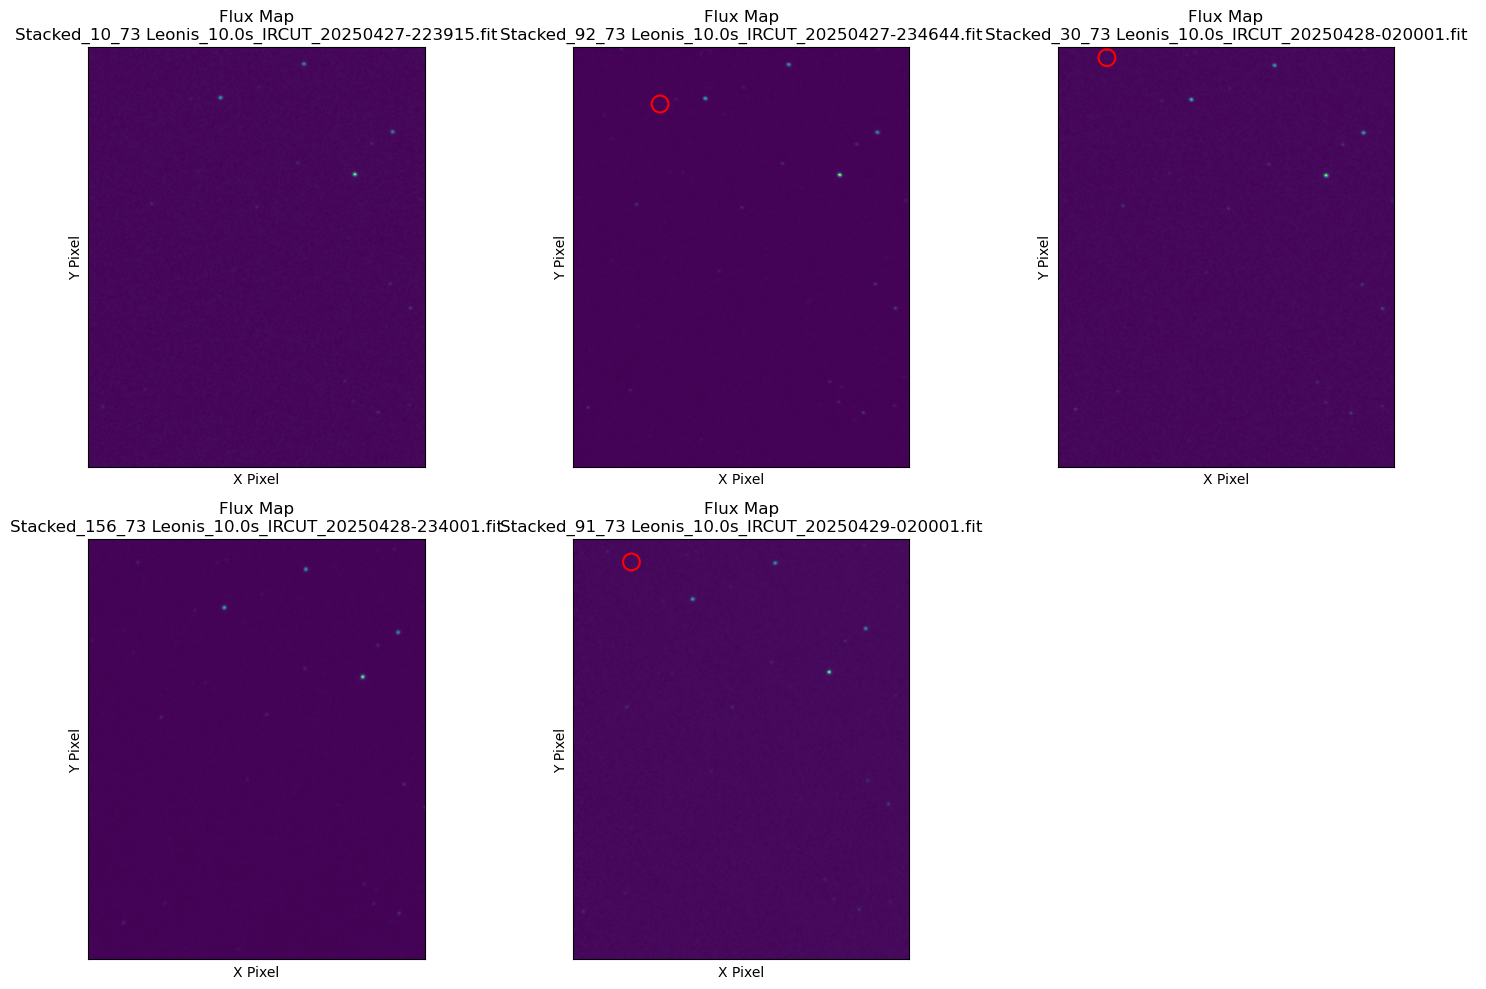

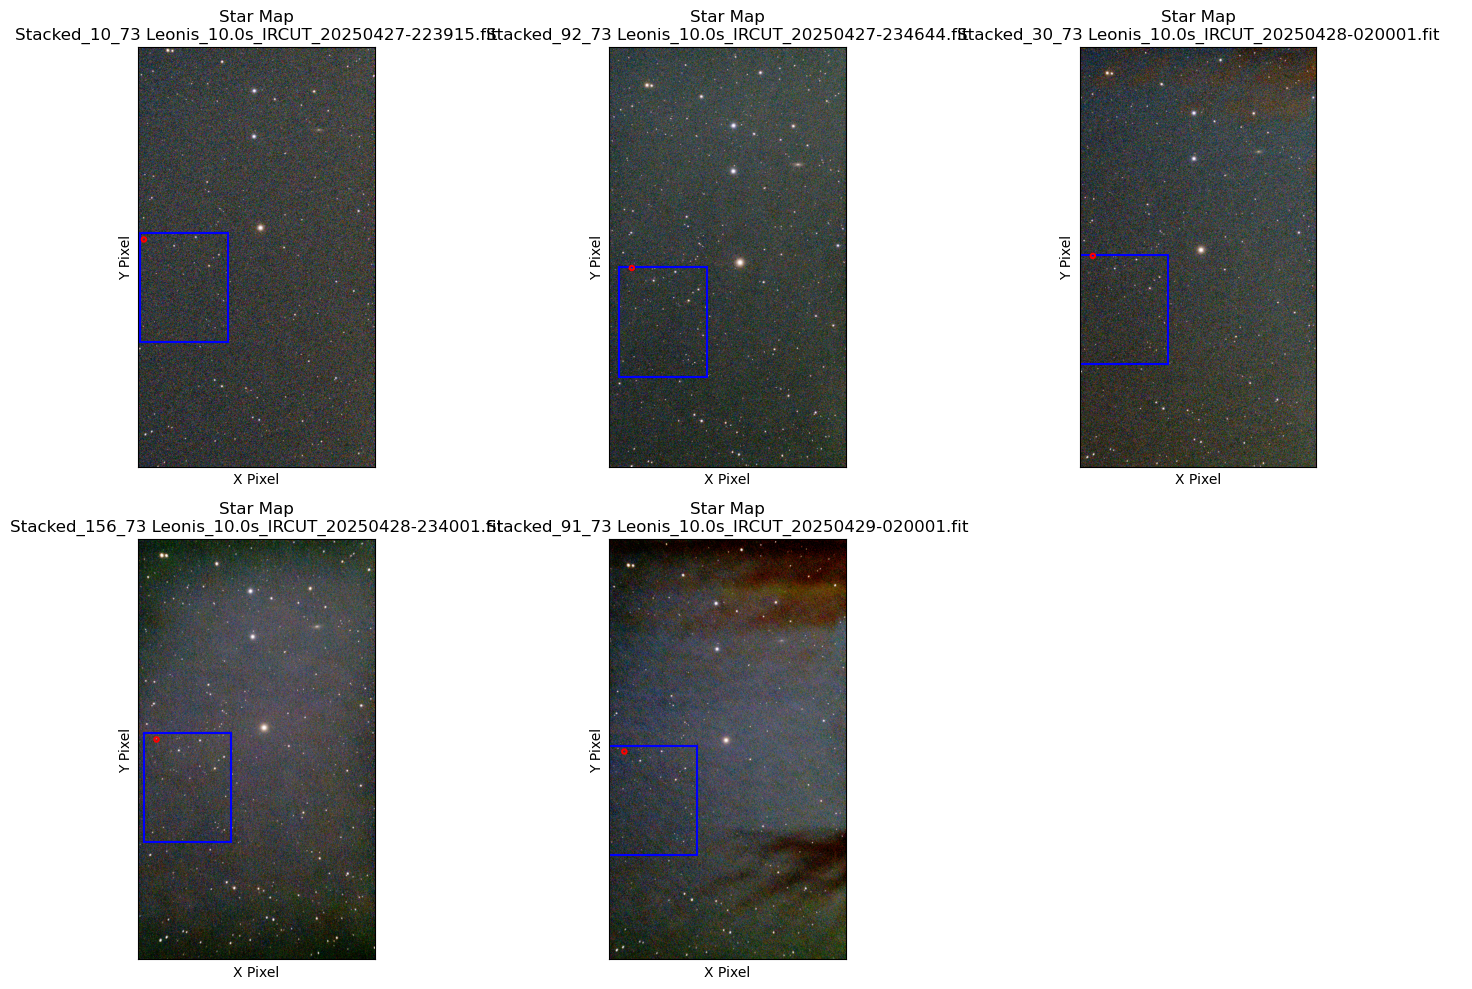

In [4]:
# Function to calculate angular distance between two WCS coordinates
def angular_distance(ra1, dec1, ra2, dec2):
    """Calculate the angular distance between two WCS coordinates."""
    return np.sqrt((ra1 - ra2)**2 + (dec1 - dec2)**2)

# Function to extract a rectangular region of interest (ROI) around the brightest object
def extract_roi(image, x_center, y_center, width, height):
    """Extract a rectangular region of interest (ROI) from the image."""
    x_start = max(0, int(x_center - width-150))
    y_start = max(0, int(y_center - height-20))
    x_end = min(image.shape[1], x_start + width)
    y_end = min(image.shape[0], y_start + height)
    return image[y_start:y_end, x_start:x_end], x_start, y_start

# Parameters for the ROI
roi_width = 400  # Width of the rectangle
roi_height = 500  # Height of the rectangle

# Placeholder for previous frame's sources and WCS
previous_sources = None
previous_wcs = None
flux_maps = []  # To store ROI flux maps for plotting
star_maps = []  # To store star maps for plotting
ra_list = []  # To store RA of moving objects
dec_list = []  # To store Dec of moving objects
distance_list = []  # To store distances of moving objects

# First loop: Perform calculations and store results


for fits_file in fits_files:
    fits_url = base_url + fits_file
    print(f"Processing: {fits_file}")

    # Fetch the FITS file
    response = requests.get(fits_url)
    response.raise_for_status()

    # Load the FITS file into an HDUList using BytesIO
    hdul = fits.open(BytesIO(response.content))

    # Extract the header and data
    header = hdul[0].header
    star_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
    hdul.close()

    # Detect sources in the current image
    bkg_sigma = mad_std(star_data)
    daofind = DAOStarFinder(fwhm=3.0, threshold=5. * bkg_sigma, min_separation=15)
    sources = daofind(star_data[:, :, 0])  # Use the first channel for detection

    # Find the brightest object in the image
    brightest_source = sources[np.argmax(sources['flux'])]
    x_brightest, y_brightest = brightest_source['xcentroid'], brightest_source['ycentroid']

    # Extract the ROI around the brightest object
    roi, x_start, y_start = extract_roi(star_data[:, :, 0], x_brightest, y_brightest, roi_width, roi_height)

    # Initialize WCS with the FITS header
    wcs = WCS(header, naxis=2)

    # Detect sources within the ROI
    bkg_sigma_roi = mad_std(roi)
    daofind_roi = DAOStarFinder(fwhm=2.0, threshold=1 * bkg_sigma_roi, min_separation=15, exclude_border=True, peakmax=brightest_source['flux'] / 5)
    sources_roi = daofind_roi(roi)

    # Find the moving object (if any)
    moving_object = None
    moving_ra = None
    moving_dec = None
    max_motion = 0
    if previous_sources is None:
        previous_sources = sources_roi
        previous_wcs = wcs
        continue
    else:
        for source in sources_roi:
            x, y = source['xcentroid'] + x_start, source['ycentroid'] + y_start
            ra, dec = wcs.all_pix2world(x, y, 1)

            for prev_source in previous_sources:
                prev_x, prev_y = prev_source['xcentroid'], prev_source['ycentroid']
                prev_ra, prev_dec = previous_wcs.all_pix2world(prev_x, prev_y, 1)

                # Calculate angular distance
                motion = angular_distance(ra, dec, prev_ra, prev_dec)

                # Check if this motion is the largest so far
                if motion > max_motion:
                    max_motion = motion
                    moving_object = (x, y)
                    moving_ra = ra
                    moving_dec = dec
                    ra_list.append(ra)
                    dec_list.append(dec)
                    distance_list.append(motion)

   
#
    # Store the ROI flux map, star map, and annotations for later plotting
    flux_maps.append((roi, fits_file, moving_object))
    star_maps.append((star_data, fits_file, x_start, y_start, moving_object))


# Second loop: Plot flux maps as 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, (roi, fits_file, moving_object) in enumerate(flux_maps):
    ax = axes[i]
    ax.imshow(roi, origin='lower', cmap='viridis')
    ax.set_title(f'Flux Map\n{fits_file}')
    ax.set_xlabel('X Pixel')
    ax.set_ylabel('Y Pixel')
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a circle for the moving object (if detected)
    if moving_object:
        circle = plt.Circle((moving_object[0] - x_start, moving_object[1] - y_start), radius=10, edgecolor='red', facecolor='none', lw=1.5)
        ax.add_patch(circle)

# Hide any unused subplots
for j in range(len(flux_maps), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Third loop: Plot star maps as 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, (star_data, fits_file, x_start, y_start, moving_object) in enumerate(star_maps):
    ax = axes[i]
    ax.imshow(apply_stretch(star_data), origin='lower', cmap='gray')
    ax.set_title(f'Star Map\n{fits_file}')
    ax.set_xlabel('X Pixel')
    ax.set_ylabel('Y Pixel')
    ax.set_xticks([])
    ax.set_yticks([])

    # Add a rectangle for the ROI
    rect = plt.Rectangle((x_start, y_start), roi_width, roi_height, edgecolor='blue', facecolor='none', lw=1.5)
    ax.add_patch(rect)

    # Add a circle for the moving object (if detected)
    if moving_object:
        circle = plt.Circle(moving_object, radius=10, edgecolor='red', facecolor='none', lw=1.5)
        ax.add_patch(circle)

# Hide any unused subplots
for j in range(len(star_maps), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [5]:
#Debugging information for future cells

print(f"Number of FITS files: {len(fits_files)}")

print(f"Length of ra_list: {len(ra_list)}")
print(f"Length of dec_list: {len(dec_list)}")
print(f"Length of distance_list: {len(distance_list)}")


Number of FITS files: 6
Length of ra_list: 286
Length of dec_list: 286
Length of distance_list: 286


# Note:

I will continue working on this project as if we are able to decern the location of the asteroid. Using Stellarium, I was able to see the trajectory of the asteroid through the night sky, and will attatch the images here. However, as we can see from the flux map (brightness map) above, the asteroid is not resolvable within the noise of the images being taken.

![Flora image 1](https://github.com/DDarrigo-Brick/PHY386/blob/main/2025/Final/DDarrigo-Brick/Flora/Data/20250427-221237png.png?raw=true)  
![Flora image 2](https://github.com/DDarrigo-Brick/PHY386/blob/main/2025/Final/DDarrigo-Brick/Flora/Data/20250427-223915png.png?raw=true)  
![Flora image 3](https://github.com/DDarrigo-Brick/PHY386/blob/main/2025/Final/DDarrigo-Brick/Flora/Data/20250427-234644png.png?raw=true)  
![Flora image 4](https://github.com/DDarrigo-Brick/PHY386/blob/main/2025/Final/DDarrigo-Brick/Flora/Data/20250428-020001png.png?raw=true)  
![Flora image 5](https://github.com/DDarrigo-Brick/PHY386/blob/main/2025/Final/DDarrigo-Brick/Flora/Data/20250428-234001png.png?raw=true)  
![Flora image 6](https://github.com/DDarrigo-Brick/PHY386/blob/main/2025/Final/DDarrigo-Brick/Flora/Data/20250429-020001png.png?raw=true)  


Reference WCS Coordinates: RA=169.25008857306858, Dec=14.017105256494988
Shifts for Stacked_10_73 Leonis_10.0s_IRCUT_20250427-223915.fit: shift_x=-5.452420737128705e-10, shift_y=-2.0069705897185486e-09
Shifts for Stacked_92_73 Leonis_10.0s_IRCUT_20250427-234644.fit: shift_x=0.18106044514343012, shift_y=0.7019053789744589
Shifts for Stacked_30_73 Leonis_10.0s_IRCUT_20250428-020001.fit: shift_x=-1.402037122169304, shift_y=1.228129462399636
Shifts for Stacked_156_73 Leonis_10.0s_IRCUT_20250428-234001.fit: shift_x=-9.29926635884027, shift_y=12.504955855909941
Shifts for Stacked_91_73 Leonis_10.0s_IRCUT_20250429-020001.fit: shift_x=12.732459980967747, shift_y=6.780386391771856


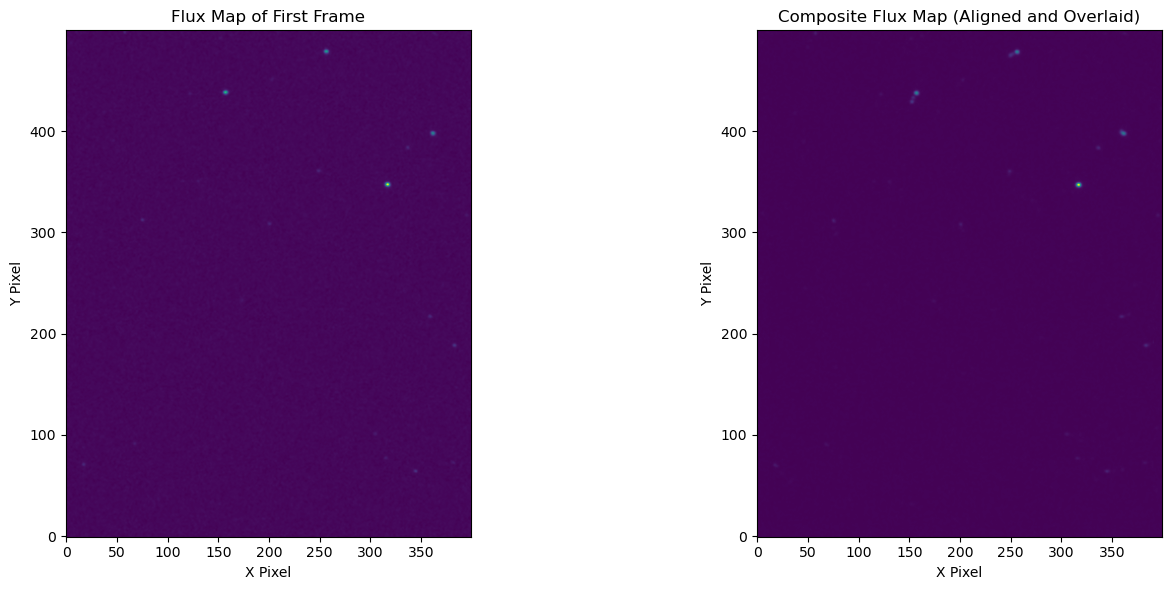

In [6]:
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord

# Initialize a composite flux map with the same shape as the ROI
composite_flux_map = np.zeros_like(flux_maps[0][0])  # Use the shape of the first ROI

# Reference WCS and position (use the first image as the reference)
reference_wcs = WCS(header, naxis=2)  # Ensure WCS is reduced to 2 dimensions
reference_ra = None
reference_dec = None

# Align and sum all the flux maps
for i, (roi, fits_file, moving_object) in enumerate(flux_maps):
    current_wcs = WCS(header, naxis=2)  # Ensure WCS is reduced to 2 dimensions

    # Detect the largest object in the entire image
    bkg_sigma = mad_std(roi)
    daofind = DAOStarFinder(fwhm=3.0, threshold=5. * bkg_sigma, min_separation=15)
    sources = daofind(roi)

    if sources is not None and len(sources) > 0:
        # Find the largest object by flux
        largest_object = sources[np.argmax(sources['flux'])]
        x_largest, y_largest = largest_object['xcentroid'], largest_object['ycentroid']

        # Convert pixel coordinates to WCS (RA, Dec)
        ra, dec = current_wcs.all_pix2world(x_largest, y_largest, 1)

        # For the first frame, set the reference RA and Dec
        if i == 0:
            reference_ra, reference_dec = ra, dec
            print(f"Reference WCS Coordinates: RA={reference_ra}, Dec={reference_dec}")

        # Convert the reference WCS coordinates back to pixel coordinates in the current frame
        ref_x, ref_y = current_wcs.all_world2pix(reference_ra, reference_dec, 1)

        # Calculate the shift needed to align the current largest object to the reference
        shift_x = ref_x - x_largest
        shift_y = ref_y - y_largest

        # Sanity check: Limit shifts to a reasonable range
        if abs(shift_x) > 50 or abs(shift_y) > 50:
            print(f"Warning: Extreme shift detected for {fits_file} (shift_x={shift_x}, shift_y={shift_y}). Skipping frame.")
            continue

        print(f"Shifts for {fits_file}: shift_x={shift_x}, shift_y={shift_y}")

        # Apply the shift to align the ROI
        aligned_roi = np.roll(np.roll(roi, int(shift_y), axis=0), int(shift_x), axis=1)

        # Add the aligned ROI to the composite flux map
        composite_flux_map += aligned_roi

# # Plot the composite flux map
# plt.figure(figsize=(8, 6))
# plt.imshow(composite_flux_map, origin='lower', cmap='viridis')
# plt.colorbar(label='Flux')
# plt.title('Composite Flux Map (Aligned and Overlayed)')
# plt.xlabel('X Pixel')
# plt.ylabel('Y Pixel')
# plt.show()
# Plot the overlaid flux map and the flux map of the first frame side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot the flux map of the first frame
axes[0].imshow(flux_maps[0][0], origin='lower', cmap='viridis')
axes[0].set_title('Flux Map of First Frame')
axes[0].set_xlabel('X Pixel')
axes[0].set_ylabel('Y Pixel')


# Plot the composite flux map
axes[1].imshow(composite_flux_map, origin='lower', cmap='viridis')
axes[1].set_title('Composite Flux Map (Aligned and Overlaid)')
axes[1].set_xlabel('X Pixel')
axes[1].set_ylabel('Y Pixel')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

Here we can see the flux maps of the ROI overlapped with each other; we can not decern any moving object.  
According to Stellarium, we should expect to see movement across the bottom-right corner (The top smudges are just artifacts of the aligning process, they are too bright to be the asteroid anyways)

### Task 2: Physical Context and Research (3 points)

- Explain what asteroids are and why tracking their motion is scientifically important.
- Describe how measuring an asteroid’s motion across the sky allows astronomers to estimate its orbit.
- Discuss how short-term observations like this one can be used to predict future positions of near-Earth objects.

#### Response

Asteroids are large clusters of rock that originate from the early days of the solar system, they follow predictable paths through space as they are influenced by the gravitational pull of nearby celestial bodies; these paths can be modeled using Kepler's Laws of planetary motion. Tracking their movement allows us to map out the space around them and image objects we may be unable to see with our telescopes.

 Using the asteroid's position at various times, we can create an approximate trajectory the asteroid takes. We can then evolve that trajectory through time by applying Kepler's laws to predict the asteroid's position at a later time with sufficient accuracy; the more data points gathered, the better the result. 

### Task 3: Data Processing and Feature Extraction (13 points)

- Pre-process the images to enhance the visibility of the asteroid (e.g., adjust contrast or apply simple filtering techniques).
- If necessary, align the images using background stars so that the asteroid's motion can be accurately tracked.
- Extract the asteroid’s position in each frame in WCS (World Coordinate System) coordinates using the FITS metadata.
- Plot the asteroid’s motion over time in a 2D plot (e.g., RA vs Dec or X vs Y), separate from the image overlays in Task 1.
- Create an additional figure that shows the displacement of the asteroid as a function of time (e.g., plot angular distance vs time).

Processing: Stacked_5_73 Leonis_10.0s_IRCUT_20250427-221237.fit
Processing: Stacked_10_73 Leonis_10.0s_IRCUT_20250427-223915.fit
Processing: Stacked_92_73 Leonis_10.0s_IRCUT_20250427-234644.fit
Processing: Stacked_30_73 Leonis_10.0s_IRCUT_20250428-020001.fit
Processing: Stacked_156_73 Leonis_10.0s_IRCUT_20250428-234001.fit
Processing: Stacked_91_73 Leonis_10.0s_IRCUT_20250429-020001.fit


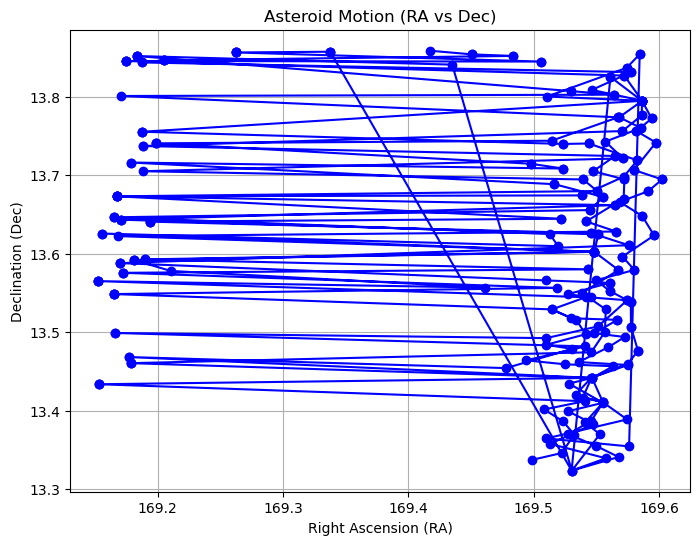

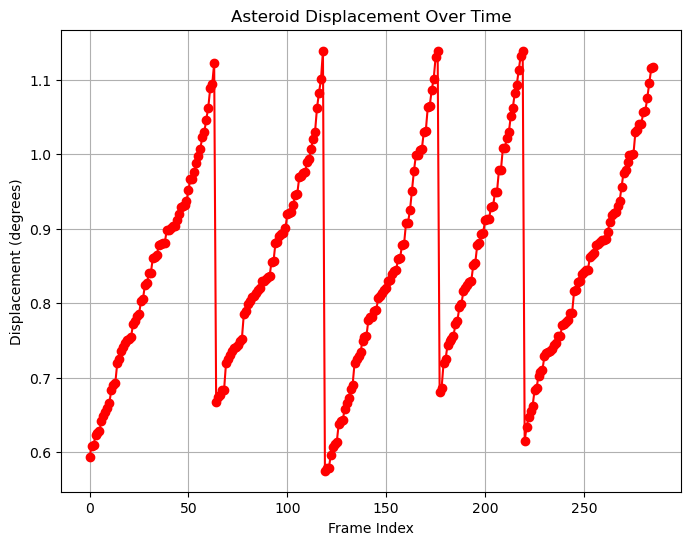

In [7]:

# Placeholder for previous frame's sources, WCS, and time
previous_sources = None
previous_wcs = None
previous_time = None

# Lists to store asteroid positions and displacements
time_list = []

# Loop through each FITS file
for fits_file in fits_files:
    fits_url = base_url + fits_file
    print(f"Processing: {fits_file}")

    # Fetch the FITS file
    response = requests.get(fits_url)
    response.raise_for_status()

    # Load the FITS file into an HDUList using BytesIO
    hdul = fits.open(BytesIO(response.content))

    # Assume the first extension contains an RGB image in (3, Height, Width) format
    star_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
    header = hdul[0].header
    hdul.close()  # Close the FITS file

    
    # Extract the observation time from the header
    observation_time = header.get('DATE-OBS')  # Replace 'DATE-OBS' with the correct keyword if different
    if observation_time:
        time_list.append(observation_time)

    # Update previous sources, WCS, and time
    previous_sources = sources
    previous_wcs = wcs
    previous_time = observation_time



# Plot the asteroid's motion over time (RA vs Dec)
plt.figure(figsize=(8, 6))
plt.plot(ra_list, dec_list, marker='o', linestyle='-', color='blue')
plt.xlabel("Right Ascension (RA)")
plt.ylabel("Declination (Dec)")
plt.title("Asteroid Motion (RA vs Dec)")
plt.grid()
plt.show()

# Plot the displacement of the asteroid as a function of time
plt.figure(figsize=(8, 6))
plt.plot(range(len(distance_list)), distance_list, marker='o', color='red')
plt.xlabel("Frame Index")
plt.ylabel("Displacement (degrees)")
plt.title("Asteroid Displacement Over Time")
plt.grid()
plt.show()

### Task 4: Modeling and Analysis (6 points)

- Calculate the asteroid’s apparent speed in arcseconds per hour using its displacement and time information from the FITS headers.
- Fit a simple linear model to its motion and assess whether its movement is approximately uniform during the observation period.
- Use the fitted model to predict the asteroid’s position one hour beyond your last observation.
- Discuss the limitations of using a linear model for longer-term predictions and what additional data would improve accuracy.

In [9]:
# Ensure consistent lengths between time_list, ra_list, and dec_list
min_length = min(len(time_list), len(ra_list), len(dec_list))
time_list = time_list[:min_length]
ra_list = ra_list[:min_length]
dec_list = dec_list[:min_length]

# Convert observation times to datetime objects, handling fractional seconds
time_list_dt = [datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in time_list]

# Calculate time differences in hours relative to the first observation
time_deltas = [(t - time_list_dt[0]).total_seconds() / 3600.0 for t in time_list_dt]

# Convert to NumPy arrays for fitting
time_deltas_np = np.array(time_deltas).reshape(-1, 1)
ra_np = np.array(ra_list).reshape(-1, 1)
dec_np = np.array(dec_list).reshape(-1, 1)

# Fit a linear model to the asteroid's motion (RA and Dec vs time)
ra_model = LinearRegression().fit(time_deltas_np, ra_np)
dec_model = LinearRegression().fit(time_deltas_np, dec_np)

# Predict the asteroid's position one hour beyond the last observation
last_time = time_deltas[-1]
future_time = last_time + 1  # One hour beyond the last observation
predicted_ra = ra_model.predict([[future_time]])[0][0]
predicted_dec = dec_model.predict([[future_time]])[0][0]

# Display results
print(f"Predicted RA: {predicted_ra:.6f}, Predicted Dec: {predicted_dec:.6f} (one hour beyond last observation)")

Predicted RA: 169.331683, Predicted Dec: 13.848722 (one hour beyond last observation)


Predicted RA: 169.331683, Predicted Dec: 13.848722 (one hour beyond last observation)


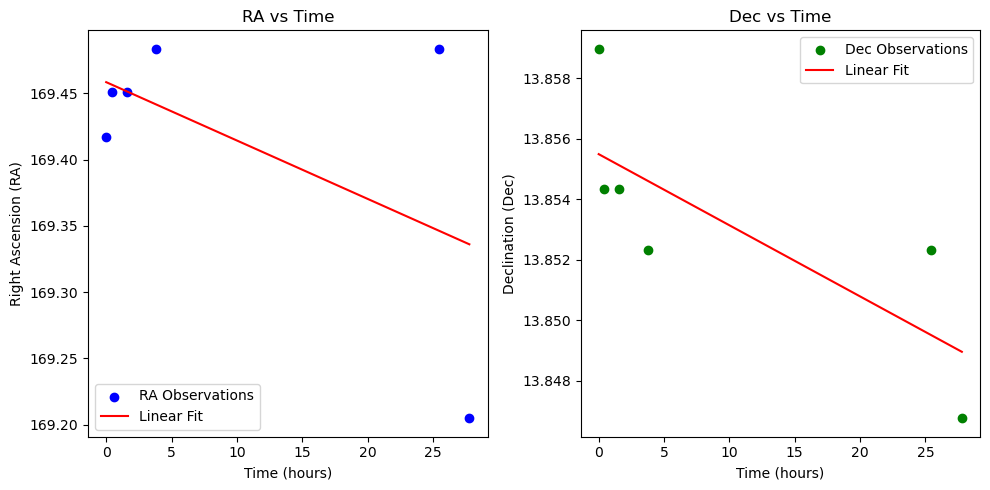

In [10]:
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Ensure consistent lengths between time_list, ra_list, and dec_list
if len(time_list) > len(ra_list):
    time_list = time_list[:len(ra_list)]

# Convert observation times to datetime objects, handling fractional seconds
time_list_dt = [datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in time_list]

# Calculate time differences in hours relative to the first observation
time_deltas = [(t - time_list_dt[0]).total_seconds() / 3600.0 for t in time_list_dt]

# Convert to NumPy arrays for fitting
time_deltas_np = np.array(time_deltas).reshape(-1, 1)
ra_np = np.array(ra_list).reshape(-1, 1)
dec_np = np.array(dec_list).reshape(-1, 1)

# Fit a linear model to the asteroid's motion (RA and Dec vs time)
ra_model = LinearRegression().fit(time_deltas_np, ra_np)
dec_model = LinearRegression().fit(time_deltas_np, dec_np)

# Predict the asteroid's position one hour beyond the last observation
last_time = time_deltas[-1]
future_time = last_time + 1  # One hour beyond the last observation
predicted_ra = ra_model.predict([[future_time]])[0][0]
predicted_dec = dec_model.predict([[future_time]])[0][0]

# Display results
print(f"Predicted RA: {predicted_ra:.6f}, Predicted Dec: {predicted_dec:.6f} (one hour beyond last observation)")

# Plot RA and Dec vs time with the fitted linear models
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(time_deltas, ra_list, color='blue', label='RA Observations')
plt.plot(time_deltas, ra_model.predict(time_deltas_np), color='red', label='Linear Fit')
plt.xlabel("Time (hours)")
plt.ylabel("Right Ascension (RA)")
plt.title("RA vs Time")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(time_deltas, dec_list, color='green', label='Dec Observations')
plt.plot(time_deltas, dec_model.predict(time_deltas_np), color='red', label='Linear Fit')
plt.xlabel("Time (hours)")
plt.ylabel("Declination (Dec)")
plt.title("Dec vs Time")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

# Discuss limitations of using a linear model
print("""
Limitations of Using a Linear Model:
1. A linear model assumes uniform motion, which may not be accurate for objects influenced by gravitational forces.
2. The asteroid's trajectory is likely curved due to orbital mechanics, making a linear fit unsuitable for long-term predictions.
3. Additional data points over a longer observation period would allow for fitting a more complex model (e.g., polynomial or orbital model).
4. Incorporating external data, such as the asteroid's orbital parameters, would improve prediction accuracy.
""")


Limitations of Using a Linear Model:
1. A linear model assumes uniform motion, which may not be accurate for objects influenced by gravitational forces.
2. The asteroid's trajectory is likely curved due to orbital mechanics, making a linear fit unsuitable for long-term predictions.
3. Additional data points over a longer observation period would allow for fitting a more complex model (e.g., polynomial or orbital model).
4. Incorporating external data, such as the asteroid's orbital parameters, would improve prediction accuracy.



# A Note on the Project as a Whole

The main issue arising from this project is the inability to properly identify the asteroid based on its movement, my code compares the WCS of all the bright objects of two adjacent frames and highlights the object that moved the most (had the greatest difference in coordinate space between the two frames).  
If the code were able to parse the asteroid's position, the fit would be much better, and the plots for displacement over time would have more than one point (each list only has one entry since it cannot resolve any useful information)

## 5. Tools and Libraries (6 points)

You are encouraged to use:
- **Astropy** for handling FITS files, WCS coordinates, and metadata.
- **skimage** for any image processing tasks like filtering or alignment.
- **Matplotlib / Seaborn** for plotting motion and displacement.
- **NumPy / SciPy** for numerical calculations and fitting linear models.

Proper use of tools and libraries will be evaluated on:
- Correct use of relevant packages for the task.
- Efficient coding practices.
- Use of appropriate data structures and functions.

## 6. Submission Instructions (8 points)

- Submit your completed notebook (.ipynb) and any additional files.
- Submit into the **`2025/Final/YourGitHubUserName`** folder in the repository.
- Deadline: During finals week.

### Submission Quality Guidelines:
- Use **docstrings** for all functions.
- Write **clear and readable code**.
- Include **comments** explaining non-obvious steps.
- Organize notebook with **markdown cells** explaining each section.
- Ensure that all **code runs without errors**.
- Use **figures and visualizations** where appropriate.

## 7. Grading Breakdown
- **Tasks Total:** 28 pts
- **Tools Use:** 6 pts
- **Submission Quality:** 8 pts
- **Total:** **42 Points**